In [13]:
import pandas as pd
import logging
import glob
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 500)
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# Download Data

In [2]:
# Ensure that the github-issues-data volume is mounted in /home/jovyan
!ls -la /home/jovyan

total 56
drwxrwsr-x 12 root   users  4096 Jun  2 16:17 .
drwxr-xr-x  1 root   root     20 Apr  6 06:04 ..
drwxrwS---  4 jovyan users  4096 Jun  2 15:48 .cache
drwxrwsr-x  3 jovyan users  4096 Jun  2 15:48 .config
drwxrwsr-x 15 jovyan users  4096 Jun  2 15:39 examples
drwxr-sr-x  2 jovyan users  4096 Jun  2 16:18 github-issues-data
drwxr-sr-x  2 jovyan users  4096 Jun  2 16:15 .ipynb_checkpoints
drwxrwsr-x  5 jovyan users  4096 Jun  2 15:40 .ipython
drwxrwsr-x  2 jovyan users  4096 Jun  2 15:57 .jupyter
drwxrwsr-x  2 jovyan users  4096 Jun  2 15:47 .keras
drwxrwS---  3 jovyan users  4096 Jun  2 15:37 .local
drwxrwS---  2 root   users 16384 Jun  2 15:35 lost+found


In [3]:
# Set path for data dir
%env DATA_DIR=/home/jovyan/github-issues-data

env: DATA_DIR=/home/jovyan/github-issues-data


In [4]:
# Download the github-issues.zip training data to /mnt/github-issues-data
!wget --directory-prefix=${DATA_DIR} https://storage.googleapis.com/kubeflow-examples/github-issue-summarization-data/github-issues.zip

# Unzip the file into /mnt/github-issues-data directory
!unzip ${DATA_DIR}/github-issues.zip -d ${DATA_DIR}

--2019-06-02 16:17:22--  https://storage.googleapis.com/kubeflow-examples/github-issue-summarization-data/github-issues.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.26.48, 2404:6800:4004:80c::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.26.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1027424178 (980M) [application/zip]
Saving to: ‘/home/jovyan/github-issues-data/github-issues.zip’

github-issues.zip   100%[===================>] 979.83M  74.5MB/s    in 14s     

2019-06-02 16:17:36 (71.6 MB/s) - ‘/home/jovyan/github-issues-data/github-issues.zip’ saved [1027424178/1027424178]

Archive:  /home/jovyan/github-issues-data/github-issues.zip
  inflating: /home/jovyan/github-issues-data/github_issues.csv  


In [4]:
# Create a symlink from <current_directory>/github-issues-data to /mnt/github-issues-data
!ln -sf ${DATA_DIR} github-issues-data

In [5]:
# Make sure that the github-issues-data symlink is created
!ls -lh github-issues-data/github_issues.csv

-rw-r--r-- 1 jovyan users 2.7G Jan 17  2018 github-issues-data/github_issues.csv


# Process Data

Split data into train and test set and preview data

In [14]:
data_file='github-issues-data/github_issues.csv'

# read in data sample 200 rows (for speed of tutorial)
# Set this to False to train on the entire dataset
use_sample_data=True

if use_sample_data:
    training_data_size=200
    traindf, testdf = train_test_split(pd.read_csv(data_file).sample(n=training_data_size), 
                                   test_size=.10)
else:
    traindf, testdf = train_test_split(pd.read_csv(data_file),test_size=.10)


#print out stats about shape of data
print(f'Train: {traindf.shape[0]:,} rows {traindf.shape[1]:,} columns')
print(f'Test: {testdf.shape[0]:,} rows {testdf.shape[1]:,} columns')

# preview data
traindf.head(3)

Train: 1,800 rows 3 columns
Test: 200 rows 3 columns


,issue_url,issue_title,body
1813266,"""https://github.com/fmadio/fmad20_issues/issues/182""",igmpv2 joins inconsistent behaviour,when issuing a large number of igmp joins on the capture interfaces ~ 100 per port. somehow only some of the joins make it to the final destination and successfully subscribe the the multicast channel. first step is to capture the actual joins being sent on the capture interfaces. maybe some of them arent actually making it onto the wire
1784011,"""https://github.com/beakerbrowser/beaker/issues/270""",wrong tooltip - tab close button,operation system: ubuntu 16.10 beaker version: 0.6.0 master:latest imo an image is worth more than 1000 words : the new tab tooltip is still active when close element is already selected. ! beaker-issueg https://cloud.githubusercontent.com/assets/374655/22203279/a4699508-e16c-11e6-9cb5-95ca21333cf6.gif
2394489,"""https://github.com/fnjv-feedback/fnjv-fonotecaneotropical/issues/18""",portal usage statistics are almost back,"thanks to the financial support of the museum of vertebrate zoology at berkeley, we have fixed the issues that were preventing us from logging the vertnet statistics of data use. usage statistics are being collected once again. we are now working on the reporting and visualization of those stats, so that we can bring those back to the natural history collections community in a friendly, useful modality. we expect all of this to be up and running before the end of the year. we apologize for a..."


**Convert to lists in preparation for modeling**

In [ ]:
train_body_raw = traindf.body.tolist()
train_title_raw = traindf.issue_title.tolist()
#preview output of first element
train_body_raw[0]

# Pre-Process Data For Deep Learning

See [this repo](https://github.com/hamelsmu/ktext) for documentation on the ktext package

In [8]:
%reload_ext autoreload
%autoreload 2
from ktext.preprocess import processor

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [9]:
# Clean, tokenize, and apply padding / truncating such that each document length = 70
#  also, retain only the top 8,000 words in the vocabulary and set the remaining words
#  to 1 which will become common index for rare words 
body_pp = processor(keep_n=8000, padding_maxlen=70)
train_body_vecs = body_pp.fit_transform(train_body_raw)

#### Look at one example of processed issue bodies

In [10]:
print('\noriginal string:\n', train_body_raw[0], '\n')
print('after pre-processing:\n', train_body_vecs[0], '\n')


original string:
 first, this is very useful, thanks for creating! i switched my emacs configuration to use dante ; because i do not want to depend either on stack/intero or ghc-mod . however, dante still depends on cabal-install and which i do not generally install because i use nix instead. is there a way to use only only ghci instead of cabal-repl ? i'm ready to give up some more features if they require cabal repl . but still depending on cabal-install is better than ghc-mod or intero ; since it's easier to install and much more common. 

after pre-processing:
 [ 104   13    8  302  512  110   14  690    6 3305   50 6245  303    4
   42 4254  141    6   44   20  123    4 2297  480   16  428 2044   24
 1118  714  212 4254  205 1508   16 2709  150    7   62    6   44   20
 1845  150  141    6   42 2045  163    8   40    5  165    4   42   73
   73 6246  163   12 2709 2046    6   59 1846    4  745   88   66  105] 



In [11]:
# Instantiate a text processor for the titles, with some different parameters
#  append_indicators = True appends the tokens '_start_' and '_end_' to each
#                      document
#  padding = 'post' means that zero padding is appended to the end of the 
#             of the document (as opposed to the default which is 'pre')
title_pp = processor(append_indicators=True, keep_n=4500, 
                     padding_maxlen=12, padding ='post')

# process the title data
train_title_vecs = title_pp.fit_transform(train_title_raw)

#### Look at one example of processed issue titles

In [12]:
print('\noriginal string:\n', train_title_raw[0])
print('after pre-processing:\n', train_title_vecs[0])


original string:
 possibility to use without cabal-install .
after pre-processing:
 [   2  832    5   23  158 1406   87    3    0    0    0    0]


Serialize all of this to disk for later use

In [13]:
import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('title_pp.dpkl', 'wb') as f:
    dpickle.dump(title_pp, f)

# Save the processed data
np.save('train_title_vecs.npy', train_title_vecs)
np.save('train_body_vecs.npy', train_body_vecs)

# Define Model Architecture

### Load the data from disk into variables

In [3]:
from seq2seq_utils import load_decoder_inputs, load_encoder_inputs, load_text_processor

In [4]:
encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_title_vecs.npy')

Shape of encoder input: (1800, 70)
Shape of decoder input: (1800, 11)
Shape of decoder target: (1800, 11)


In [5]:
num_encoder_tokens, body_pp = load_text_processor('body_pp.dpkl')
num_decoder_tokens, title_pp = load_text_processor('title_pp.dpkl')

Size of vocabulary for body_pp.dpkl: 8002
Size of vocabulary for title_pp.dpkl: 4158


/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Define Model Architecture

In [8]:
%matplotlib inline
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras import optimizers

In [9]:
#arbitrarly set latent dimension for embedding and hidden units
latent_dim = 300

##### Define Model Architecture ######

########################
#### Encoder Model ####
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding for encoder (ex: Issue Body)
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Intermediate GRU layer (optional)
#x = GRU(latent_dim, name='Encoder-Intermediate-GRU', return_sequences=True)(x)
#x = BatchNormalization(name='Encoder-Batchnorm-2')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)

# Encapsulate the encoder as a separate entity so we can just 
#  encode without decoding if we want to.
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

########################
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

########################
#### Seq2Seq Model ####

#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


** Examine Model Architecture Summary **

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 300)    1247400     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 300)    1200        Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

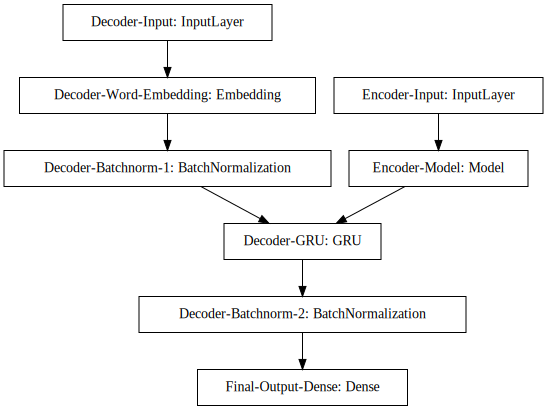

In [6]:
from seq2seq_utils import viz_model_architecture
seq2seq_Model.summary()
viz_model_architecture(seq2seq_Model)

# Train Model

In [8]:
import numpy as np
from keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'tutorial_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 1200
epochs = 7
history = seq2seq_Model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1584 samples, validate on 216 samples
Epoch 1/7
1584/1584 [==============================] - 13s 8ms/step - loss: 8.3049 - val_loss: 7.1726


/opt/conda/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/7
1584/1584 [==============================] - 11s 7ms/step - loss: 7.0294 - val_loss: 6.3375
Epoch 3/7
1584/1584 [==============================] - 11s 7ms/step - loss: 6.2218 - val_loss: 5.8373
Epoch 4/7
1584/1584 [==============================] - 11s 7ms/step - loss: 5.7035 - val_loss: 5.4728
Epoch 5/7
1584/1584 [==============================] - 11s 7ms/step - loss: 5.3119 - val_loss: 5.2600
Epoch 6/7
1584/1584 [==============================] - 11s 7ms/step - loss: 4.9847 - val_loss: 5.0687
Epoch 7/7
1584/1584 [==============================] - 11s 7ms/step - loss: 4.7163 - val_loss: 4.9491


In [9]:
#save model
seq2seq_Model.save('seq2seq_model_tutorial.h5')

# See Example Results On Holdout Set

It is useful to see examples of real predictions on a holdout set to get a sense of the performance of the model.  We will also evaluate the model numerically in a following section.

In [10]:
from seq2seq_utils import Seq2Seq_Inference
seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                 decoder_preprocessor=title_pp,
                                 seq2seq_model=seq2seq_Model)

In [15]:
# this method displays the predictions on random rows of the holdout set
seq2seq_inf.demo_model_predictions(n=50, issue_df=testdf)



============== Example # 97 =================

"https://github.com/FirefoxUX/photon/issues/170"
Issue Body:
 define document, modify, finalise assets, finalise copy, extra checks. 

Original Title:
 radio buttons components: define

****** Machine Generated Title (Prediction) ******:
 expectation try rgb linking titlers zenhub quote tuning robo binding coral been


============== Example # 195 =================

"https://github.com/faceyspacey/redux-first-router/issues/90"
Issue Body:
 the onbeforechange function is not promise aware. this makes it very hard to involve any async operation to decide whether we cancel the route through dispatching a redirect or not. would be great to have a onbeforechange function which will honor: 1. a promise dispatched from within onbeforechange like redux-thunk 2. or will await a promise returned from onbeforechange and will evaluate the skipping after the promise resolved. this will enable a lot of possible use-cases like authentication an existin


****** Machine Generated Title (Prediction) ******:
 cluck closed src autograded subdirectory django lektor charaset compatible usddefault usddefault feeds


============== Example # 173 =================

"https://github.com/intel/intel-cmt-cat/issues/61"
Issue Body:
 hi once again! with reference to 57, i've updated to a kernel that allows me to use the per-thread monitoring capability more specifically, 4.13 . while using the api, i.e. _ ./monitor_app -i _ also reports this i get the following warning: > warn: as of kernel 4.10, intel r rdt perf results per core are found to be incorrect. could i get any information as to what results are incorrect? should i not take any measurements obtained with the api for granted? also, does this mean per-thread results are incorrect as well? regards, toni 

Original Title:
 thread-level monitoring 2

****** Machine Generated Title (Prediction) ******:
 terrain spinner switch предпросмотр cheryl accordion web ts nomethoderror wrong createdataad


****** Machine Generated Title (Prediction) ******:
 sequelize thumbnail enjoyable lastest manuals spam eraikinak review parsing total pivot inicio


============== Example # 106 =================

"https://github.com/KyberNetwork/smart-contracts/issues/10"
Issue Body:
 during contract upgrades change only the pointer in the dummy contract. this is in addition or instead of ens domain, 

Original Title:
 store kybernetwork contract latest address in a dummy contract

****** Machine Generated Title (Prediction) ******:
 cluck closed src autograded subdirectory parser collapsible plexpy allows helm wc clone


============== Example # 82 =================

"https://github.com/betaflight/betaflight-tx-lua-scripts/issues/15"
Issue Body:
 i have the bf lua script installed on x7. i can read the values when i power on my quad. but i can't scroll up and down with the wheel . it's like the wheel is not working in the script page. i have last open tx nb and last bf lua script. thanks for your h


****** Machine Generated Title (Prediction) ******:
 sequelize thumbnail signatures story enh triggered versus webdrivers issues звонка inform findpoas


# Evaluate Model: BLEU Score

For machine-translation tasks such as this one, it is common to measure the accuracy of results using the [BLEU Score](https://en.wikipedia.org/wiki/BLEU).  The convenience function illustrated below uses [NLTK's corpus_bleu](https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.corpus_bleu).  The output of the below convenience function is an Average of BlEU-1, BLEU-2, BLEU-3 and BLEU-4. 

In [16]:
#convenience function that generates predictions on holdout set and calculates BLEU Score

bleu_score = seq2seq_inf.evaluate_model(holdout_bodies=testdf.body.tolist(), 
                                        holdout_titles=testdf.issue_title.tolist(), 
                                        max_len_title=12)

/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [17]:
print(f'BLEU Score (avg of BLUE 1-4) on Holdout Set: {bleu_score * 100}')

BLEU Score (avg of BLUE 1-4) on Holdout Set: 1.1214381572182756e-229
